In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nltk

In [2]:
df = pd.read_table("../../Data/practice_data.tsv",encoding= 'unicode_escape')

# Keyword Overlap

In [3]:
# First get the dataframe of just the citing and cited tited as well as teh class label
title_df = df[["citing_title", "cited_title", "citation_class_label", "citation_influence_label"]]
title_df.head()

citing_title  \
0  Ontology-Based Recommendation of Editorial Pro...   
1  Ontology-Based Recommendation of Editorial Pro...   
2  Ontology-Based Recommendation of Editorial Pro...   
3  Ontology-Based Recommendation of Editorial Pro...   
4  Ontology-Based Recommendation of Editorial Pro...   

                                         cited_title  citation_class_label  \
0  Web search personalization with ontological us...                     5   
1             Exploring Scholarly Data with Rexplore                     0   
2  Klink-2: Integrating Multiple Web Sources to G...                     0   
3  Forecasting the Spreading of Technologies in R...                     0   
4  Supporting Springer Nature Editors by means of...                     5   

   citation_influence_label  
0                         0  
1                         0  
2                         0  
3                         1  
4                         1

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("wordnet")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 

def drop_stop_words(title):
    """Drop the core english stopwords in a title. Additionally stem and lemmatize them as well."""
    
    # Break apart hyphenated words
    hyphen_split = title.split('-')
    title = " ".join(hyphen_split)
    
    # First tokenize the input to break it into parts
    word_tokens = word_tokenize(title)
    
    # Get the set of stop words
    stop_words = set(stopwords.words('english'))
    
    # Filter and reconstruct. Also stem the words
    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()
    filtered_sentence = [lemmatizer.lemmatize(w.lower()) for w in word_tokens if not w in stop_words]  
  
    return filtered_sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\angik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Create a new column in the dataframe to store the overlap feature
title_df["keyword_overlap"] = np.zeros(title_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in title_df.index:
    # Grab the citing and cited title
    citing_title = title_df.iloc[row]["citing_title"]
    cited_title = title_df.iloc[row]["cited_title"]
    
    # Compute the filtered versions of both
    citing_words = drop_stop_words(citing_title)
    cited_words = drop_stop_words(cited_title)
    
    # Count the overlap
    overlap = len(set(citing_words) & set(cited_words)) 
    title_df.loc[row,"keyword_overlap"] = overlap

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Number of verbs + Verb Tense

In [6]:
def count_verbs(context):
    """Given a citation context, break it into words and return the number of verbs."""
    
    context_words = word_tokenize(context)
    tags = nltk.pos_tag(context_words)
    verb_count = 0
    for tag in tags:
        if "VB" in tag[1]:
            verb_count += 1
    
    return verb_count

In [7]:
# Create a new column in the dataframe to store the num verbs feature
df["num_verbs"] = np.zeros(title_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in title_df.index:
    # Grab the citation context
    context = df.iloc[row]["citation_context"]
    
    # Compute the verb count
    verb_count = count_verbs(context)
    
    # Count the overlap
    df.at[row,"num_verbs"] = verb_count

In [8]:
def count_verbs_tense(context, tense):
    """Given a citation context, break it into words and return the number of verbs."""
    
    context_words = word_tokenize(context)
    tags = nltk.pos_tag(context_words)
    verb_count = 0
    for tag in tags:
        if tense in tag[1]:
            verb_count += 1
    
    return verb_count

In [9]:
tenses = ["VB","VBZ", "VBG", "VBN", "VBD"]
for tense in tenses:
    # Create feature
    feature_name = f"num_verbs_{tense}"
    df[feature_name] = np.zeros(df.shape[0])

    # Traverse through all the rows of the dataframe and generate the new feature
    for row in df.index:
        # Grab the citation context
        context = df.iloc[row]["citation_context"]

        # Compute the verb count
        verb_count = count_verbs_tense(context, tense)

        # Count the overlap
        df.at[row,feature_name] = verb_count

# Structural features

In [10]:
df['citation_rel_loc'] = (df['citation_context'].str.index("#AUTHOR_TAG")) / (df['citation_context'].str.len() - 11)

In [11]:
citation_rel_punc = []
for i in range(len(df)):
    text = df['citation_context'].iloc[i]
    ind = text.index('#AUTHOR_TAG')
    val = -1
    start = 0
    end = len(text) - 1
    for j in range(ind, 0, -1):
        if text[j] == ',' or text[j] == '.' or text[j] == ';':
            start = j
            break
    for j in range(ind, len(text)):
        if text[j] == ',' or text[j] == '.' or text[j] == ';':
            end = j
            break
    end -= 10
    val = (ind - start) / (end - start)
    citation_rel_punc.append(val)

df['citation_rel_punc'] = citation_rel_punc

In [12]:
df['citation_len'] = df['citation_context'].str.split().str.len() - 1 # -1 for #AUTHOR_TAG

In [13]:
df['num_citations'] = df['citation_context'].str.count('\[') - df['citation_context'].str.count('\[#AUTHOR_TAG\]')

In [14]:
citation_in_paren = []
for i in range(len(df)):
    text = df['citation_context'].iloc[i]
    ind = text.index('#AUTHOR_TAG')
    flag = 0
    for j in range(ind, len(text)):
        if text[j] == ')':
            for k in range(j, 0, -1):
                if text[k] == '(':
                    if ind > k and ind < j:
                        flag = 1
    citation_in_paren.append(flag)

df['citation_in_paren'] = citation_in_paren

In [15]:
active_verb = []
for i in range(len(df)):
    text = nltk.word_tokenize(df['citation_context'].iloc[i])
    pos_tagged = nltk.pos_tag(text)
    for s in [y[0] for y in pos_tagged]:
        if 'AUTHOR_TAG' in s:
            index = [y[0] for y in pos_tagged].index(s)
            break
    if index != len(pos_tagged) - 1 and 'VB' in pos_tagged[index + 1][1]:
        active_verb.append(1)
    else:
        active_verb.append(0)
        
df['active_verb'] = active_verb

In [16]:
desc = []
for i in range(len(df)):
    text = df['citation_context'].iloc[i]
    ind = text.index('#AUTHOR_TAG')
    flag = 0
    for j in range(ind, len(text)):
        if text[j] == ',':
            if text[j + 2] == 'a':
                flag = 1
            break
    desc.append(flag)

df['citation_description'] = desc

# Sentence Pattern

In [17]:
#from getSentencePattern import get_custom_pattern_features_wrapper, countCases

#sent_pat_feature = df['citation_context'].apply(get_custom_pattern_features_wrapper)

In [18]:
#types = ['Background', 'CompareOrContrast', 'Prior', 'Future', 'Motivation', 'Uses']

#for i in range(len(types)):
    # Convert each feature into a number (count the cases)
    #score = sent_pat_feature.apply(countCases, args=(types[i], ))
    #feature_name = f"sentence_pattern_{types[i]}"
    #df[feature_name] = score

# Stop Word Embedding

In [19]:
df["tokens"] = [word_tokenize(context.replace("#AUTHOR_TAG", "")) for context in df["citation_context"]]


threshold = 3 #frequency threshold for throwing out words

tokenized_corpus = []
[tokenized_corpus.extend(word_tokenize(context.replace("#AUTHOR_TAG", ""))) for context in df["citation_context"]]
fdist = nltk.FreqDist(tokenized_corpus)
fdftotal = pd.DataFrame(fdist.items(), columns = ['word', 'freq'])
fdf = fdftotal.loc[fdftotal.freq > threshold]

In [20]:
glovepath = "../../Utilties/glove"
embeddings_dict = {}
with open(glovepath + "/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [21]:
#Generate embeddings out of tokenized sentences
def embed_context(tokens, fdf):
    vector = []
    for word in tokens:
        if word in fdf["word"].values and word in embeddings_dict:
            vector.append(embeddings_dict[word])
    return np.sum(vector, axis=0)

X = np.array([embed_context(tokens, fdf) for tokens in df["tokens"]])

In [22]:
temp = []
for i in range(len(X)):
    t = tuple(X[i])
    temp.append(t)

# Concatenate features

In [23]:
df['embedding'] = list(zip(df.num_verbs, df.num_verbs_VB, df.num_verbs_VBD, 
                           df.num_verbs_VBN, df.num_verbs_VBG, df.num_verbs_VBZ, df.citation_rel_loc,
                           df.citation_rel_punc, df.citation_len, df.num_citations, df.citation_in_paren,
                           df.active_verb, df.citation_description))
#df.sentence_pattern_Background,
#df.sentence_pattern_CompareOrContrast, df.sentence_pattern_Motivation, df.sentence_pattern_Uses))
#Not working for some reason
#  keyword_overlap, df.sentence_pattern_Prior, and df.sentence_pattern_Future are all array of 0's.
embed = []
for i in range(len(df)):
    t = df['embedding'].iloc[i] + temp[i]
    embed.append(t)
    
# Normalize features
temp1 = pd.DataFrame(np.array(embed))
for c in temp1.columns:
    if temp1[c].max() == temp1[c].min():
        print(c)
    temp1[c] = (temp1[c] - temp1[c].min()) / (temp1[c].max() - temp1[c].min())

e1 = list(map(tuple, np.array(temp1)))

df['embedding'] = e1

In [24]:
df['embedding'].head()

0    (0.09523809523809523, 0.09523809523809523, 0.0...
1    (0.2857142857142857, 0.2857142857142857, 0.333...
2    (0.23809523809523808, 0.23809523809523808, 0.1...
3    (0.38095238095238093, 0.38095238095238093, 0.2...
4    (0.3333333333333333, 0.3333333333333333, 0.0, ...
Name: embedding, dtype: object

# Train basic models

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# ROC with a model (vector feature)
def rocm(X, y, model, title = "Influence Label"):
    # generate 2 class dataset
    X = np.array([*X])
    # split into train/test sets
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    # fit a model
    model.fit(trainX, trainy)
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

    # plot the roc curve for the model
    fpr, tpr, thresholds = roc_curve(testy, lr_probs)

    # Plot the curve
    '''
    plt.figure(figsize = (10,6))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
    plt.plot([0,1],[0,1], linestyle = "--", c = "k")
    plt.show()
    '''
    
def mmrocm(X, y, model):
    for i in range(6):
        y_i = []
        for j in range(len(y)):
            if y.iloc[j] != i:
                y_i.append(0)
            else:
                y_i.append(1)
        title = "Class Label {}".format(i)
        rocm(X, y_i, model, title)
        
def eval_inf(X, y, model):
    X = np.array([*X])
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    model.fit(trainX, trainy)
    predy = model.predict(testX)
    score = f1_score(testy, predy)
    print("Influence F1 score: {}".format(score))
    
def eval_class(X, y, model):
    X = np.array([*X])
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    model.fit(trainX, trainy)
    predy = model.predict(testX)
    score = f1_score(testy, predy, average = 'macro')
    print("Class F1 score: {}".format(score))

### Logistic Regression

In [26]:
logreg = LogisticRegression(max_iter = 1000)
rocm(df['embedding'], df['citation_influence_label'], logreg)
mmrocm(df['embedding'], df['citation_class_label'], logreg)
eval_inf(df['embedding'], df['citation_influence_label'], logreg)
eval_class(df['embedding'], df['citation_class_label'], logreg)

Logistic: ROC AUC=0.620
Logistic: ROC AUC=0.726
Logistic: ROC AUC=0.703
Logistic: ROC AUC=0.648
Logistic: ROC AUC=0.344
Logistic: ROC AUC=0.597
Logistic: ROC AUC=0.738
Influence F1 score: 0.4768211920529801
Class F1 score: 0.18366724526144818


### XGBoost

In [27]:
import xgboost as xgb

xgbreg = xgb.XGBClassifier(n_estimators=100, max_depth=3)

rocm(df['embedding'], df['citation_influence_label'], xgbreg)
mmrocm(df['embedding'], df['citation_class_label'], xgbreg)
eval_inf(df['embedding'], df['citation_influence_label'], xgbreg)
eval_class(df['embedding'], df['citation_class_label'], xgbreg)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Logistic: ROC AUC=0.705
[18:47:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Logistic: ROC AUC=0.740
[18:47:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Logistic: ROC AUC=0.714
[18:47:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Logistic: ROC AUC=0.664
[18:47:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Logistic: ROC AUC=0.475
[18:47:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Logistic: ROC AUC=0.653
[18:47:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Logistic: ROC AUC=0.714
[18:47:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Influence F1 score: 0.5813953488372092
[18:47:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:47:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Class F1 score: 0.29556638993316625


### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

rfclf=RandomForestClassifier(n_estimators=100)

rocm(df['embedding'], df['citation_influence_label'], rfclf)
mmrocm(df['embedding'], df['citation_class_label'], rfclf)
eval_inf(df['embedding'], df['citation_influence_label'], rfclf)
eval_class(df['embedding'], df['citation_class_label'], rfclf)

Logistic: ROC AUC=0.688
Logistic: ROC AUC=0.767
Logistic: ROC AUC=0.708
Logistic: ROC AUC=0.536
Logistic: ROC AUC=0.682
Logistic: ROC AUC=0.613
Logistic: ROC AUC=0.718
Influence F1 score: 0.5212121212121212
Class F1 score: 0.29979943452429225


### Smol Neural Network

In [29]:
from torch import nn

input_dim = len(df['embedding'].iloc[0])

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(input_dim, 64)
        # Output layer, 2
        self.output = nn.Linear(64, 2)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
scaler = StandardScaler()
comparison_dict = {}
solvers = ['lbfgs', 'adam']
activation_functions = ['tanh']
hidden_layer_sizes = [(64,), (128,), (256,), (64, 64,), (128, 64,), (256, 64,), (256, 128,), (256, 256,)]

In [32]:
from sklearn.model_selection import cross_validate 
def nrocm(X, y, model, title = "Influence Label"):
    # generate 2 class dataset
    X = np.array([*X])
    # split into train/test sets
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    scaler.fit(trainX)
    trainX=scaler.transform(trainX)
    scaler.fit(testX)
    testX=scaler.transform(testX)
    # fit a model
    model.fit(trainX, trainy)
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = roc_auc_score(testy, lr_probs)
    comparison_dict[count] = {"solver": solver, "activation_function": ac,
                                      "hidden_layers": hidden_layer_config,
                              "auc_score": lr_auc,
                              "accuracy": model.score(testX, testy), "loss": model.loss_}
    print ("Accuracy", comparison_dict[count]['accuracy'], "Loss", comparison_dict[count]["loss"])
    # summarize scores
    print('Neural: ROC AUC=%.3f' % (lr_auc))
    print (type(X))
    print (type(y))
    #cv_results = cross_validate(model, X.reshape(-1,1), y, cv=10, 
                            #return_train_score=False, 
                            #scoring=model.score) 
    #print("Fit scores: {}".format(cv_results['test_score']))
    # plot the roc curve for the model
    fpr, tpr, thresholds = roc_curve(testy, lr_probs)

    # Plot the curve
    
    plt.figure(figsize = (10,6))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
    plt.plot([0,1],[0,1], linestyle = "--", c = "k")
    plt.show()

    
def nmmrocm(X, y, model):
    for i in range(6):
        y_i = []
        for j in range(len(y)):
            if y.iloc[j] != i:
                y_i.append(0)
            else:
                y_i.append(1)
        title = "Class Label {}".format(i)
        rocm(X, y_i, model, title)
        
def neval_inf(X, y, model):
    X = np.array([*X])
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    model.fit(trainX, trainy)
    predy = model.predict(testX)
    score = f1_score(testy, predy)
    print("Influence F1 score: {}".format(score))
    
def neval_class(X, y, model):
    X = np.array([*X])
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    model.fit(trainX, trainy)
    predy = model.predict(testX)
    score = f1_score(testy, predy, average = 'macro')
    print("Class F1 score: {}".format(score))

On model #1
Accuracy 0.605 Loss 0.0002260506009746976
Neural: ROC AUC=0.615
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


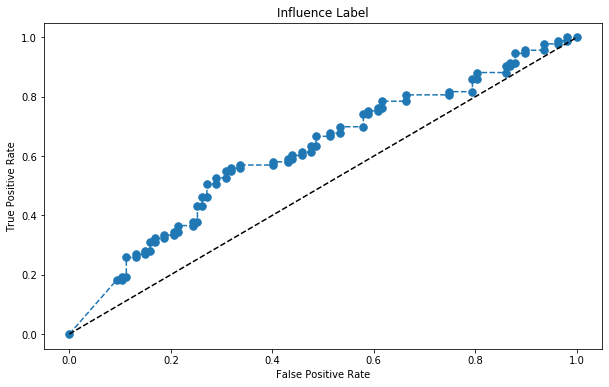

Influence F1 score: 0.5913978494623656
On model #2
Accuracy 0.61 Loss 0.00014871558731419847
Neural: ROC AUC=0.663
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


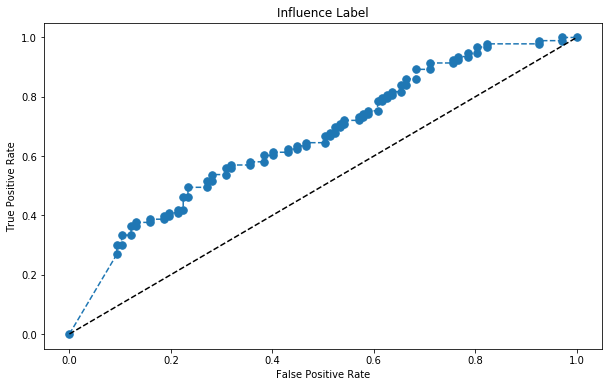

Influence F1 score: 0.5425531914893618
On model #3
Accuracy 0.665 Loss 0.00035851806495652426
Neural: ROC AUC=0.683
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


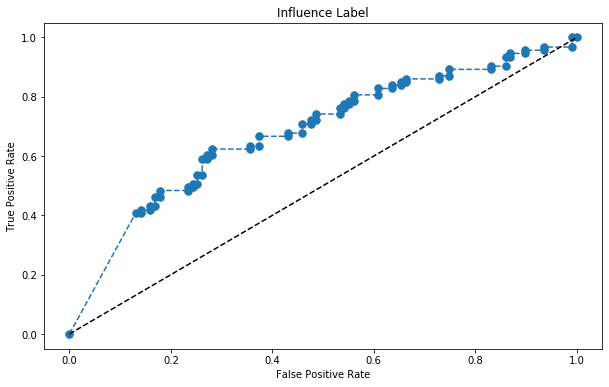

Influence F1 score: 0.5745856353591161
On model #4
Accuracy 0.655 Loss 5.318014855987274e-05
Neural: ROC AUC=0.638
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


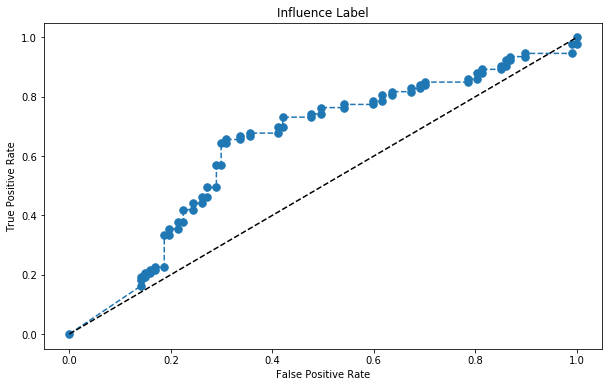

Influence F1 score: 0.5604395604395604
On model #5
Accuracy 0.7 Loss 7.092034018466693e-05
Neural: ROC AUC=0.704
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


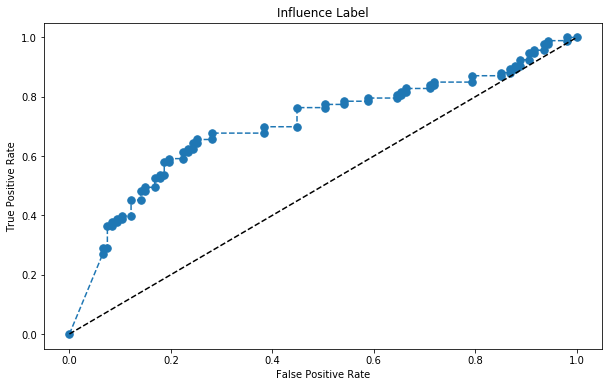

Influence F1 score: 0.6276595744680852
On model #6
Accuracy 0.665 Loss 7.707065869515869e-05
Neural: ROC AUC=0.742
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


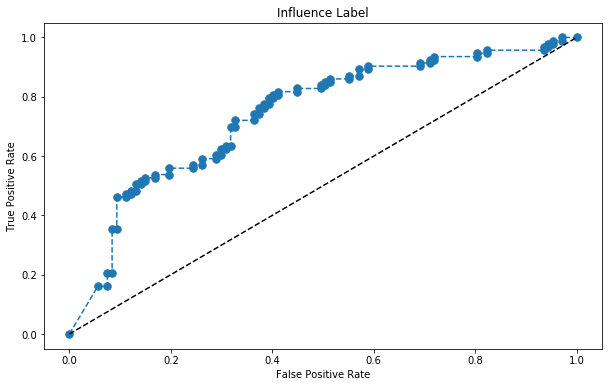

Influence F1 score: 0.5745856353591161
On model #7
Accuracy 0.645 Loss 8.821512946545658e-05
Neural: ROC AUC=0.653
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


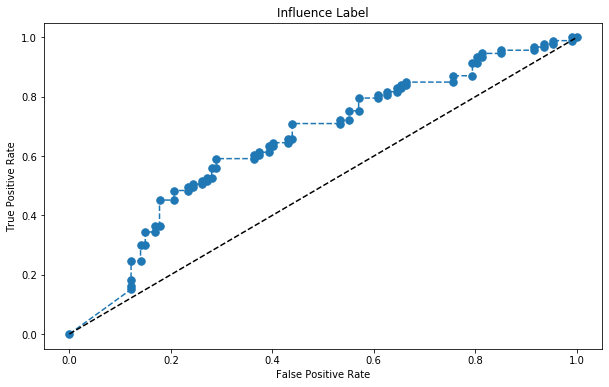

Influence F1 score: 0.6063829787234043
On model #8
Accuracy 0.67 Loss 5.15990903309801e-05
Neural: ROC AUC=0.697
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


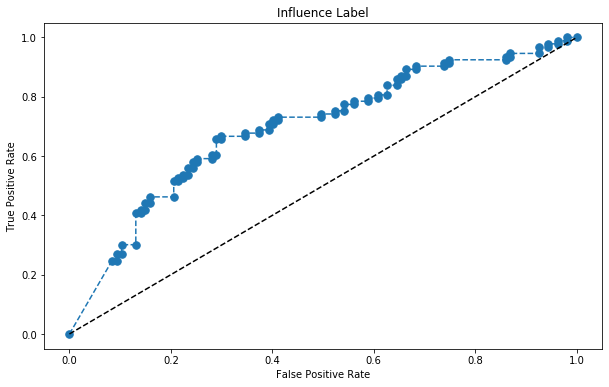

Influence F1 score: 0.6057142857142858
On model #9
Accuracy 0.615 Loss 0.014866032100392626
Neural: ROC AUC=0.698
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


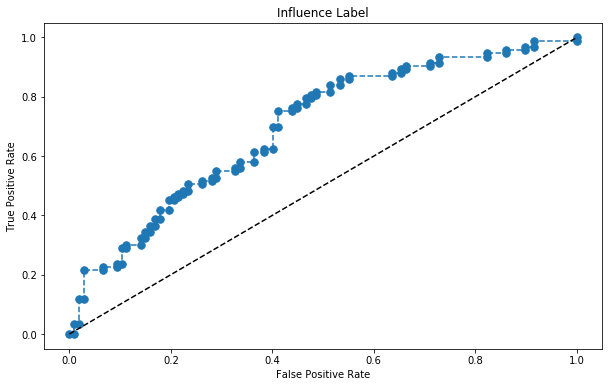

Influence F1 score: 0.5333333333333333
On model #10
Accuracy 0.645 Loss 0.018291243952948538
Neural: ROC AUC=0.711
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


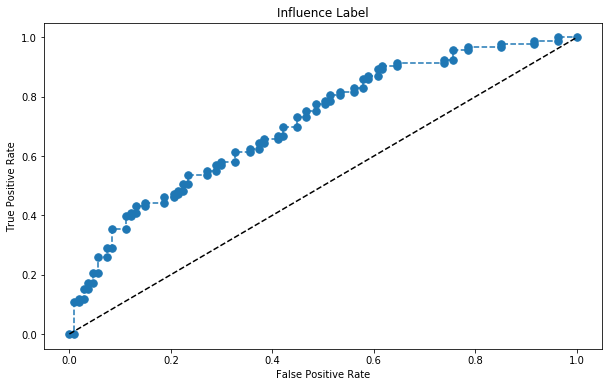

Influence F1 score: 0.4903225806451614
On model #11
Accuracy 0.685 Loss 0.014451378070938874
Neural: ROC AUC=0.722
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


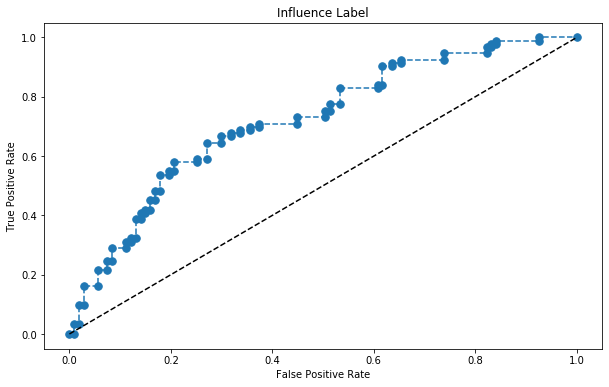

Influence F1 score: 0.5212121212121212
On model #12
Accuracy 0.655 Loss 0.020181998891087245
Neural: ROC AUC=0.694
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


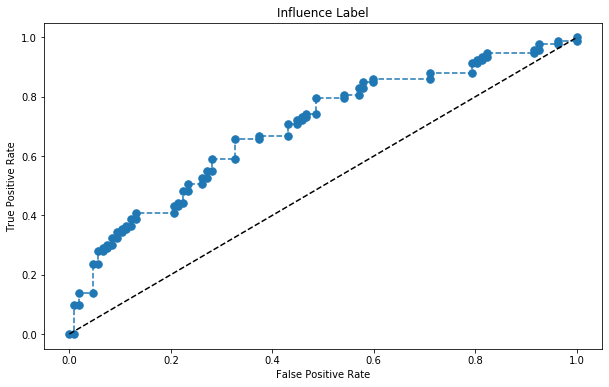

Influence F1 score: 0.5816326530612245
On model #13
Accuracy 0.675 Loss 0.026856787541303728
Neural: ROC AUC=0.741
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


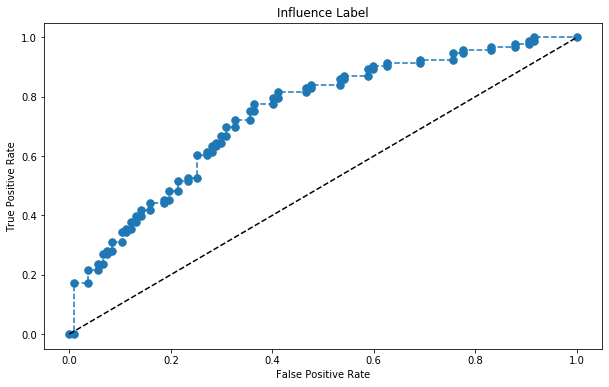

Influence F1 score: 0.42028985507246375
On model #14
Accuracy 0.605 Loss 0.017769970344928474
Neural: ROC AUC=0.688
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


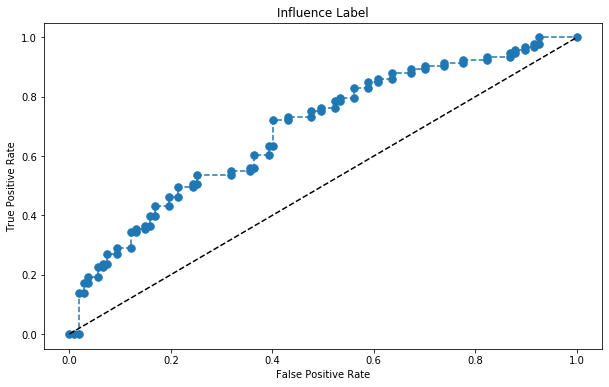

Influence F1 score: 0.2608695652173913
On model #15
Accuracy 0.695 Loss 0.023199860088115108
Neural: ROC AUC=0.721
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


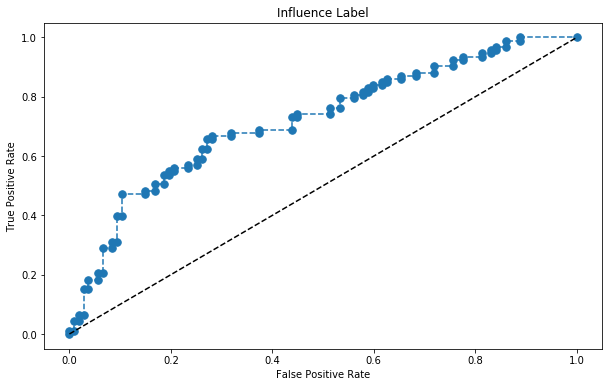

Influence F1 score: 0.3442622950819672
On model #16
Accuracy 0.66 Loss 0.019736184945078273
Neural: ROC AUC=0.731
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


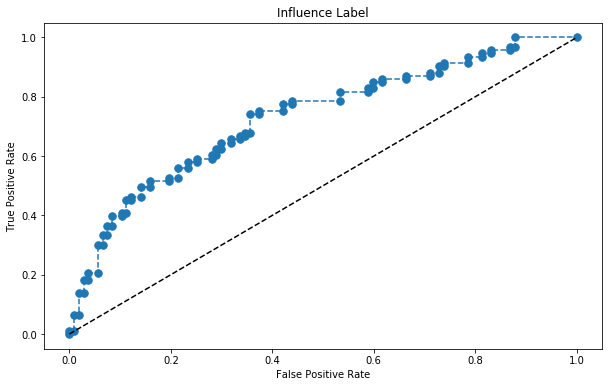

Influence F1 score: 0.44776119402985076


In [33]:
count = 1
for solver in solvers:
    for ac in activation_functions:
        for hidden_layer_config in hidden_layer_sizes:
            print("On model #%d" % (count))
            nclf = MLPClassifier(solver=solver, alpha=1e-5, hidden_layer_sizes=hidden_layer_config,
                                random_state=1, max_iter=15000, activation=ac)
            nrocm(df['embedding'], df['citation_influence_label'], nclf)
            neval_inf(df['embedding'], df['citation_influence_label'], nclf)
            count += 1

In [34]:
comparison_df = pd.DataFrame(comparison_dict).T
comparison_df['accuracy'] = pd.to_numeric(comparison_df['accuracy'])
comparison_df.to_excel('InfluenceComparisonDict.xlsx')

In [35]:
max_a_index = comparison_df['accuracy'].idxmax()
row = comparison_df.loc[max_a_index]
print("The best accuracy score out of %d models is for" % (count - 1))
print(row)

The best accuracy score out of 16 models is for
solver                       lbfgs
activation_function           tanh
hidden_layers            (128, 64)
auc_score                 0.704201
accuracy                       0.7
loss                   7.09203e-05
Name: 5, dtype: object


Accuracy 0.665 Loss 7.707065869515869e-05
Neural: ROC AUC=0.742
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


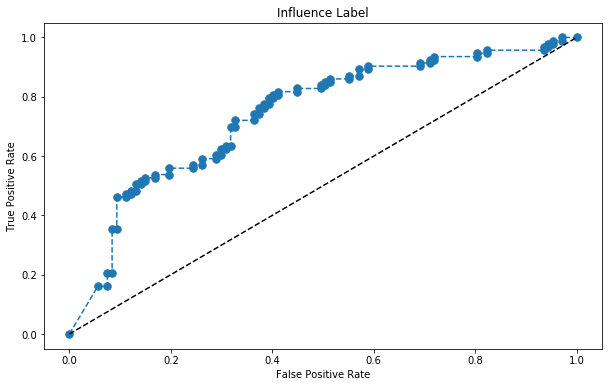

Influence F1 score: 0.5745856353591161


In [36]:
nclf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(256,64),
                                random_state=1, max_iter=15000, activation='tanh')
nrocm(df['embedding'], df['citation_influence_label'], nclf)
neval_inf(df['embedding'], df['citation_influence_label'], nclf)

Accuracy 0.7 Loss 7.092034018466693e-05
Neural: ROC AUC=0.704
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


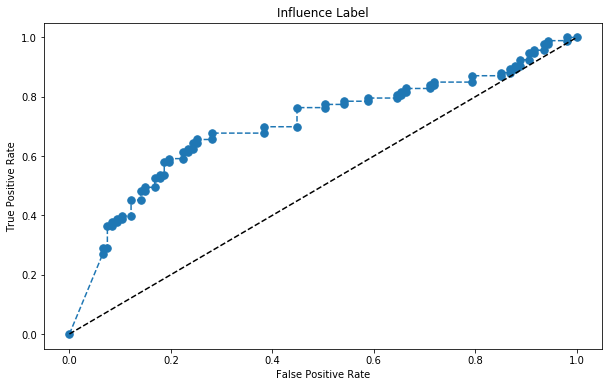

Influence F1 score: 0.6276595744680852


In [37]:
nclf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(128,64),
                                random_state=1, max_iter=15000, activation='tanh')
nrocm(df['embedding'], df['citation_influence_label'], nclf)
neval_inf(df['embedding'], df['citation_influence_label'], nclf)

In [38]:
print(df['embedding'])
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

0      (0.09523809523809523, 0.09523809523809523, 0.0...
1      (0.2857142857142857, 0.2857142857142857, 0.333...
2      (0.23809523809523808, 0.23809523809523808, 0.1...
3      (0.38095238095238093, 0.38095238095238093, 0.2...
4      (0.3333333333333333, 0.3333333333333333, 0.0, ...
                             ...                        
995    (0.3333333333333333, 0.3333333333333333, 0.111...
996    (0.5714285714285714, 0.5714285714285714, 0.444...
997    (0.14285714285714285, 0.14285714285714285, 0.1...
998    (0.5714285714285714, 0.5714285714285714, 0.444...
999    (0.09523809523809523, 0.09523809523809523, 0.1...
Name: embedding, Length: 1000, dtype: object


In [39]:

def knrocm(X, y, clf, title = "Influence Label"):
    # generate 2 class dataset
    X = np.array([*X])
    scaler.fit(X)
    X=scaler.transform(X)
    kf = KFold(n_splits=3)
    # split into train/test sets
    for train_indices, test_indices in kf.split(X):
        clf.fit(X[train_indices], y[train_indices])
        print(clf.score(X[test_indices], y[test_indices]))
        lr_probs = clf.predict_proba(X[test_indices])
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        # calculate scores
        lr_auc = roc_auc_score(y[test_indices], lr_probs)
        # summarize scores
        print('K Fold Cross: ROC AUC=%.3f' % (lr_auc))
        fpr, tpr, thresholds = roc_curve(y[test_indices], lr_probs)
        # plot the roc curve for the mode
    
        plt.figure(figsize = (10,6))
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
        plt.plot([0,1],[0,1], linestyle = "--", c = "k")
        plt.show()
#####
    
def knmmrocm(X, y, model):
    for i in range(6):
        y_i = []
        for j in range(len(y)):
            if y.iloc[j] != i:
                y_i.append(0)
            else:
                y_i.append(1)
        title = "Class Label {}".format(i)
        rocm(X, y_i, model, title)
        
def kneval_inf(X, y, model):
    X = np.array([*X])
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    model.fit(trainX, trainy)
    predy = model.predict(testX)
    score = f1_score(testy, predy)
    print("Influence F1 score: {}".format(score))
    
def kneval_class(X, y, model):
    X = np.array([*X])
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    model.fit(trainX, trainy)
    predy = model.predict(testX)
    score = f1_score(testy, predy, average = 'macro')
    print("Class F1 score: {}".format(score))

0.47005988023952094
K Fold Cross: ROC AUC=0.492


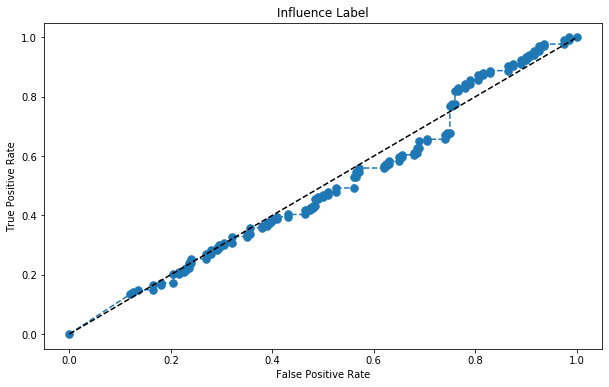

0.5075075075075075
K Fold Cross: ROC AUC=0.546


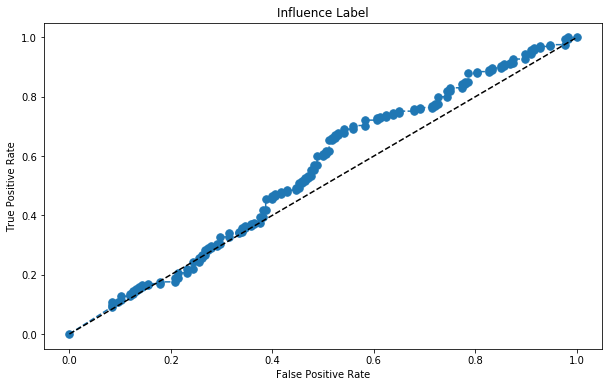

0.5495495495495496
K Fold Cross: ROC AUC=0.531


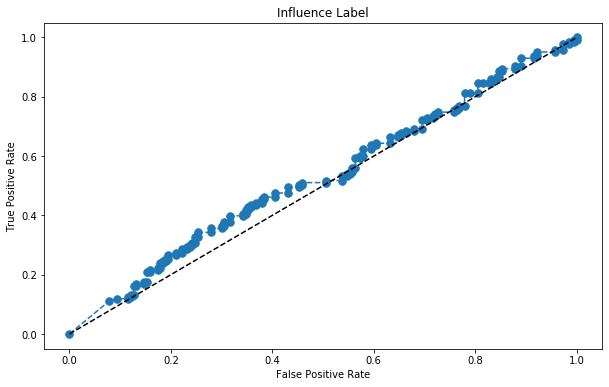

In [40]:
nclf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(256,64),
                                random_state=1, max_iter=15000, activation='tanh')
knrocm(df['embedding'], df['citation_influence_label'], nclf)

In [42]:
df.head()


unique_id    core_id                                       citing_title  \
0       CC1  158977742  Ontology-Based Recommendation of Editorial Pro...   
1       CC2  158977742  Ontology-Based Recommendation of Editorial Pro...   
2       CC3  158977742  Ontology-Based Recommendation of Editorial Pro...   
3       CC4  158977742  Ontology-Based Recommendation of Editorial Pro...   
4       CC5  158977742  Ontology-Based Recommendation of Editorial Pro...   

              citing_author  \
0  Thiviyan Thanapalasingam   
1  Thiviyan Thanapalasingam   
2  Thiviyan Thanapalasingam   
3  Thiviyan Thanapalasingam   
4  Thiviyan Thanapalasingam   

                                         cited_title cited_author  \
0  Web search personalization with ontological us...         Sieg   
1             Exploring Scholarly Data with Rexplore      Osborne   
2  Klink-2: Integrating Multiple Web Sources to G...      Osborne   
3  Forecasting the Spreading of Technologies in R...      Osborne   
4  Supporting Springer Nature Editors by means of...      Osborne   

                                    citation_context  citation_class_label  \
0  They usually generate user models that describ...                     5   
1  The Computer Science Ontology (CSO)[3]is a lar...                     0   
2  In order to do so, we characterized all SN pub...                     0   
3  This API supports a number of applications, in...                     0   
4  It works according to three main steps:1) It r...                     5   

   citation_influence_label  num_verbs  ...  num_verbs_VBD  citation_rel_loc  \
0                         0        2.0  ...            0.0          1.000000   
1                         0        6.0  ...            3.0          0.994681   
2                         0        5.0  ...            1.0          1.000000   
3                         1        8.0  ...            2.0          0.324324   
4                         1        7.0  ...            0.0          0.706612   

   citation_rel_punc  citation_len  num_citations  citation_in_paren  \
0           1.000000            15              0                  0   
1           0.994681            26              2                  0   
2           1.000000            31              0                  0   
3           0.970588            58              2                  0   
4           0.584795            37              0                  0   

   active_verb  citation_description  \
0            0                     0   
1            0                     0   
2            0                     0   
3            0                     1   
4            0                     0   

                                              tokens  \
0  [They, usually, generate, user, models, that, ...   
1  [The, Computer, Science, Ontology, (, CSO, ), ...   
2  [In, order, to, do, so, ,, we, characterized, ...   
3  [This, API, supports, a, number, of, applicati...   
4  [It, works, according, to, three, main, steps:...   

                                           embedding  
0  (0.09523809523809523, 0.09523809523809523, 0.0...  
1  (0.2857142857142857, 0.2857142857142857, 0.333...  
2  (0.23809523809523808, 0.23809523809523808, 0.1...  
3  (0.38095238095238093, 0.38095238095238093, 0.2...  
4  (0.3333333333333333, 0.3333333333333333, 0.0, ...  

[5 rows x 24 columns]

In [44]:
features=df[['unique_id', 'core_id', 'citation_influence_label', 'embedding']].copy()
features.to_csv('Old_Train_Features.csv')